In [1]:
# Load Model
%pylab inline
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import os

from model import *

from src.modeling.run_model_single import (
    load_model, load_inputs, process_augment_inputs, batch_to_tensor
)

import sys
sys.path.append('../OncoNet_Public')
sys.path.append('../')

import torch
import torch.nn as nn
from torchgpipe import GPipe
import onconet.utils.parsing_with_line as parsing
import onconet.models.factory as model_factory
import torchvision
from torchvision import datasets, models, transforms

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
print(torch.cuda.is_available())

Populating the interactive namespace from numpy and matplotlib
cuda
True


In [2]:
shared_parameters = {
    "device_type": "gpu",
    "gpu_number": 0,
    "max_crop_noise": None,
    "max_crop_size_noise": None,
    "batch_size": 4,
    "seed": 0,
    "augmentation": False,
    "use_hdf5": False,
}

In [3]:
random_number_generator = np.random.RandomState(shared_parameters["seed"])

image_only_parameters = shared_parameters.copy()
image_only_parameters["view"] = "L-CC"
image_only_parameters["use_heatmaps"] = False
image_only_parameters["model_path"] = "models/ImageOnly__ModeImage_weights.p"
model, _ = load_model(image_only_parameters)
#model = nn.DataParallel(model)
model = model.to(device)

In [4]:
model

SingleImageBreastModel(
  (view_resnet): ViewResNetV2(
    (first_conv): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), bias=False)
    (first_pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (layer_list): ModuleList(
      (0): Sequential(
        (0): BasicBlockV2(
          (relu): ReLU(inplace=True)
          (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (downsample): Sequential(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
        (1): BasicBlockV2(
          (relu): ReLU(inplace=True)
          (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=Tr

In [5]:
pretrained_dict = {key.replace("module.", ""): value for key, value in torch.load('best_model_4_t3p.pt').items()}
model.load_state_dict(pretrained_dict)

<All keys matched successfully>

In [6]:
model.state_dict().keys()

odict_keys(['view_resnet.first_conv.weight', 'view_resnet.layer_list.0.0.bn1.weight', 'view_resnet.layer_list.0.0.bn1.bias', 'view_resnet.layer_list.0.0.bn1.running_mean', 'view_resnet.layer_list.0.0.bn1.running_var', 'view_resnet.layer_list.0.0.bn1.num_batches_tracked', 'view_resnet.layer_list.0.0.conv1.weight', 'view_resnet.layer_list.0.0.bn2.weight', 'view_resnet.layer_list.0.0.bn2.bias', 'view_resnet.layer_list.0.0.bn2.running_mean', 'view_resnet.layer_list.0.0.bn2.running_var', 'view_resnet.layer_list.0.0.bn2.num_batches_tracked', 'view_resnet.layer_list.0.0.conv2.weight', 'view_resnet.layer_list.0.0.downsample.0.weight', 'view_resnet.layer_list.0.1.bn1.weight', 'view_resnet.layer_list.0.1.bn1.bias', 'view_resnet.layer_list.0.1.bn1.running_mean', 'view_resnet.layer_list.0.1.bn1.running_var', 'view_resnet.layer_list.0.1.bn1.num_batches_tracked', 'view_resnet.layer_list.0.1.conv1.weight', 'view_resnet.layer_list.0.1.bn2.weight', 'view_resnet.layer_list.0.1.bn2.bias', 'view_resnet.la

In [7]:
model.view_resnet.layer_list[4][1]

BasicBlockV2(
  (relu): ReLU(inplace=True)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)

In [9]:
model

SingleImageBreastModel(
  (view_resnet): ViewResNetV2(
    (first_conv): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), bias=False)
    (first_pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (layer_list): ModuleList(
      (0): Sequential(
        (0): BasicBlockV2(
          (relu): ReLU(inplace=True)
          (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (downsample): Sequential(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
        (1): BasicBlockV2(
          (relu): ReLU(inplace=True)
          (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=Tr

In [12]:
class GradCam(nn.Module):
    def __init__(self, model, layer):
        super(GradCam, self).__init__()
        
        self.model = model
        self.final_layer = layer
        
        self.gradients = None
        self.fmaps = None
        
        def save_fmaps(mod, ip, out):
            self.fmaps = out
            #print("Fmaps")
            return None
        
        def save_grads(mod, ip, out):
            self.gradients = out[0]
            #print("Grads")
            return None
    
        self.final_layer.register_forward_hook(save_fmaps)
        self.final_layer.register_backward_hook(save_grads)
    
    def forward(self, x):
        out = self.model(x)
        out = F.softmax(out[:, 1])
        
        logit = torch.round(out)[:, 1]
        #print(logit)
        
        self.model.zero_grad()
        logit.backward()
        
        grads = self.get_grads()
        fmaps = self.get_fmaps()
        
        #print(grads.nonzero())
        #print(fmaps.nonzero())
        
        pooled_gradients = torch.mean(grads, dim=[1,2,3])
        #print(pooled_gradients.size())
        
        # weight the channels by corresponding gradients
        for i in range(pooled_gradients.size()[-1]):
            fmaps[:, i, :, :] *= pooled_gradients[i]
        
        # average the channels of the activations
        heatmap = torch.mean(fmaps, dim=1).squeeze()

        # relu on top of the heatmap
        # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
        heatmap = np.maximum(heatmap.cpu().detach(), 0)

        # normalize the heatmap
        heatmap /= torch.max(heatmap)

        # draw the heatmap
        plt.imshow(heatmap.squeeze(), cmap='jet')
    
        #print(fmaps)
        
        torch.cuda.empty_cache()
        
        return heatmap
            
    # method for the gradient extraction
    def get_grads(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_fmaps(self):
        return self.fmaps
    

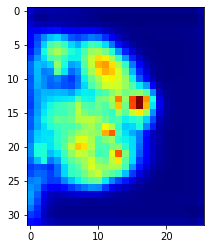

In [13]:
from mit_risk_data import MammoBCRiskDataset, Resize, FaceLeft, FaceRight, NormalizePix, ToTensor3D, mammo_collate
trans = transforms.Compose([FaceRight(), NormalizePix(7047.99, 12005.5), ToTensor3D()])

risk_dataset_t3 = torch.load('../time_set/risk_pred_GEHolo_4view_matchedSepCase_T3.pt')
risk_dataset_t3.transform = trans
risk_dataset_t3.transform

model.eval()
g = GradCam(model, model.view_resnet)

img = risk_dataset_t3[23]['images']['same-cc'].reshape(1, 1, 2048, 1664).type(torch.FloatTensor).to(device)
a = g(img)

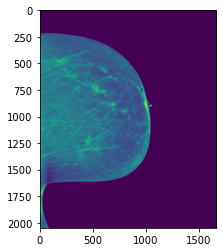

In [14]:
plt.imshow(img.squeeze().cpu().numpy())

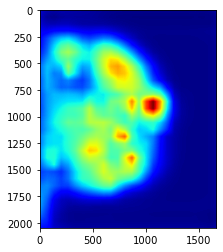

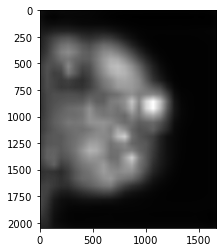

In [15]:
import matplotlib.cm as cm

heatmap = np.uint8(F.interpolate(a.reshape(1, 1, 32, 26), (2048, 1664), mode='bilinear', align_corners=True).squeeze() * 255)
plt.imshow(heatmap, cmap='jet')
plt.show()

plt.imshow(heatmap, cmap='gray')
plt.show()

In [16]:
heatmap.shape

(2048, 1664)

In [17]:
img_np = img.cpu().numpy()

In [18]:
superimposed_img = heatmap.squeeze() * 0.8 + img_np.squeeze()

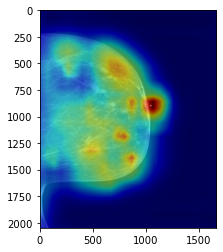

In [19]:
plt.imshow(img.squeeze().cpu().numpy(), cmap='gray')
plt.imshow(heatmap, cmap='jet', alpha=0.6)
plt.axis('on')
plt.show()

In [36]:
def show_heatmap(img, alpha=0.7):
    random_number_generator = np.random.RandomState(shared_parameters["seed"])

    image_only_parameters = shared_parameters.copy()
    image_only_parameters["view"] = "L-CC"
    image_only_parameters["use_heatmaps"] = False
    image_only_parameters["model_path"] = "models/ImageOnly__ModeImage_weights.p"
    mod, _ = load_model(image_only_parameters)
    mod = model.to(device)
    
    mod.eval()
    out = F.softmax(mod(img)[:, 1])
    print(out[:, 1])
    
    gradcam = GradCam(mod, mod.view_resnet)
    
    heatmap = gradcam(img)
    heatmap_interp = np.uint8(F.interpolate(heatmap.reshape(1, 1, 32, 26), (2048, 1664), mode='bilinear', align_corners=True).squeeze() * 255)
    plt.imshow(img.squeeze().cpu().numpy(), cmap='gray')
    plt.imshow(heatmap_interp, cmap='jet', alpha=alpha)
    plt.axis('on')
    plt.show()

tensor([0.0099], device='cuda:0', grad_fn=<SelectBackward>)


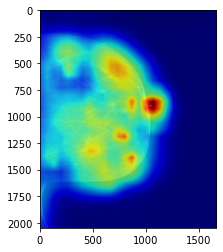

In [37]:
show_heatmap(img, alpha=0.8)

Label:  tensor(1, dtype=torch.uint8)


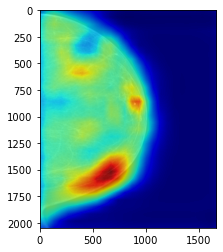

Label:  tensor(1, dtype=torch.uint8)


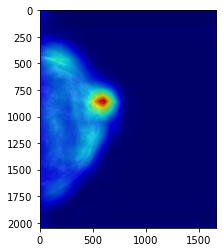

Label:  tensor(1, dtype=torch.uint8)


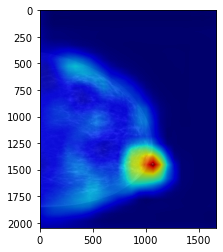

Label:  tensor(1, dtype=torch.uint8)


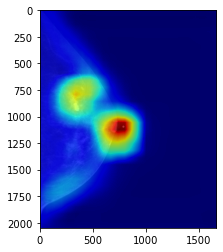

Label:  tensor(1, dtype=torch.uint8)


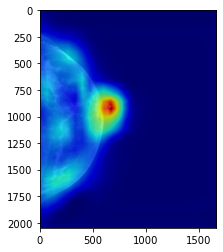

Label:  tensor(1, dtype=torch.uint8)


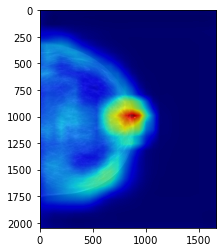

Label:  tensor(1, dtype=torch.uint8)


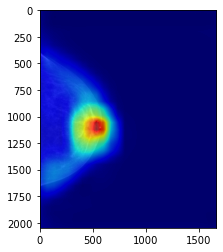

Label:  tensor(1, dtype=torch.uint8)


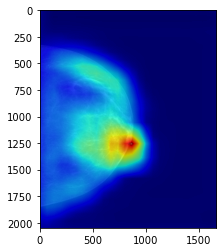

Label:  tensor(1, dtype=torch.uint8)


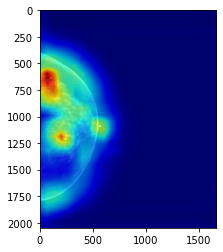

Label:  tensor(1, dtype=torch.uint8)


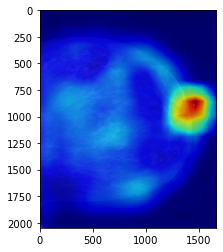

Label:  tensor(1, dtype=torch.uint8)


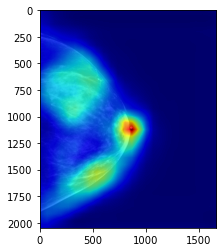

Label:  tensor(1, dtype=torch.uint8)


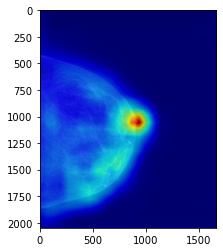

Label:  tensor(1, dtype=torch.uint8)


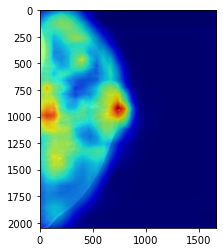

Label:  tensor(1, dtype=torch.uint8)


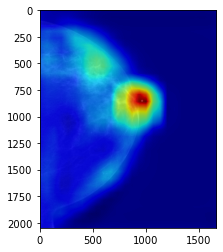

Label:  tensor(1, dtype=torch.uint8)


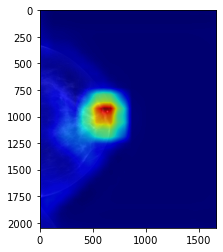

Label:  tensor(1, dtype=torch.uint8)


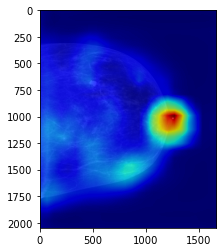

Label:  tensor(1, dtype=torch.uint8)


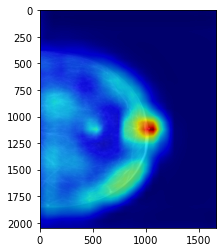

Label:  tensor(1, dtype=torch.uint8)


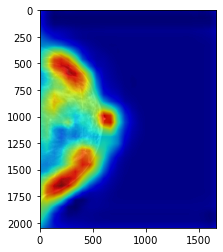

Label:  tensor(1, dtype=torch.uint8)


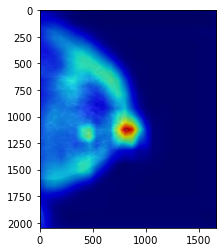

Label:  tensor(1, dtype=torch.uint8)


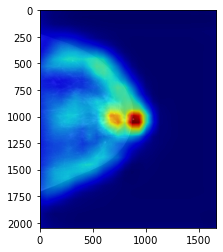

Label:  tensor(1, dtype=torch.uint8)


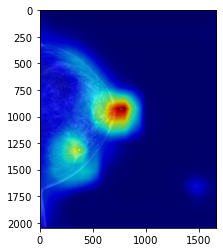

Label:  tensor(1, dtype=torch.uint8)


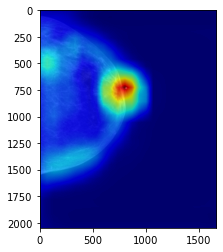

Label:  tensor(1, dtype=torch.uint8)


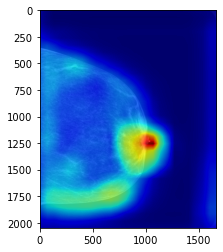

Label:  tensor(1, dtype=torch.uint8)


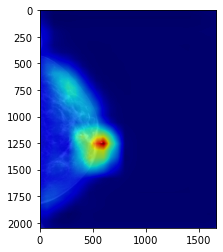

Label:  tensor(1, dtype=torch.uint8)


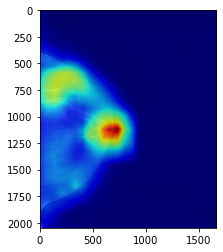

Label:  tensor(1, dtype=torch.uint8)


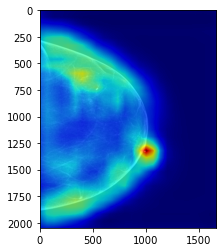

Label:  tensor(1, dtype=torch.uint8)


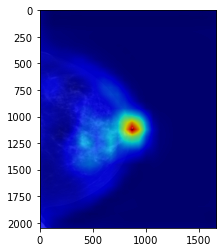

Label:  tensor(1, dtype=torch.uint8)


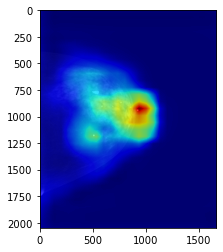

Label:  tensor(1, dtype=torch.uint8)


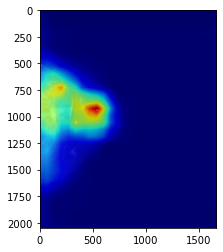

Label:  tensor(1, dtype=torch.uint8)


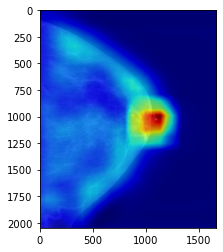

Label:  tensor(1, dtype=torch.uint8)


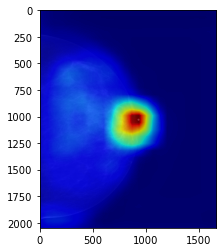

Label:  tensor(1, dtype=torch.uint8)


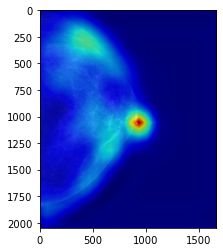

Label:  tensor(1, dtype=torch.uint8)


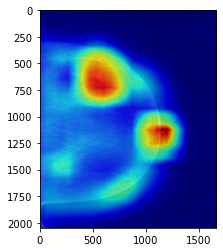

Label:  tensor(1, dtype=torch.uint8)


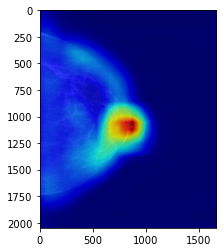

Label:  tensor(1, dtype=torch.uint8)


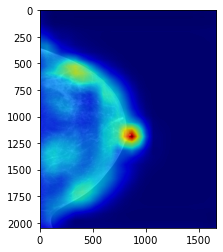

Label:  tensor(1, dtype=torch.uint8)


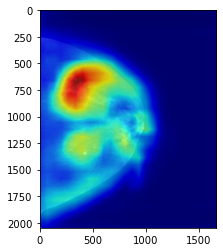

Label:  tensor(1, dtype=torch.uint8)


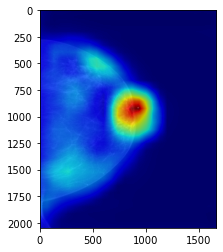

Label:  tensor(1, dtype=torch.uint8)


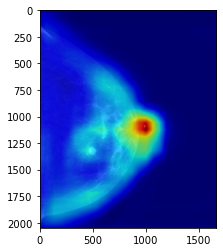

Label:  tensor(1, dtype=torch.uint8)


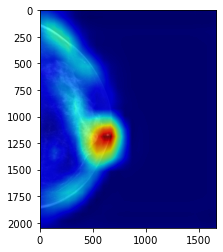

Label:  tensor(1, dtype=torch.uint8)


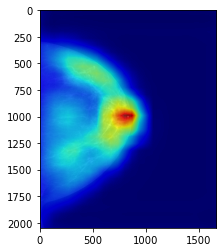

Label:  tensor(1, dtype=torch.uint8)


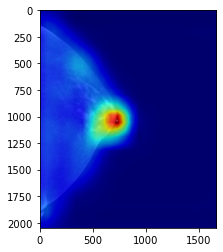

Label:  tensor(1, dtype=torch.uint8)


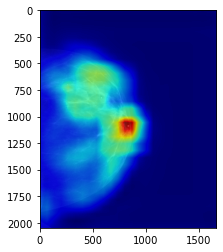

Label:  tensor(1, dtype=torch.uint8)


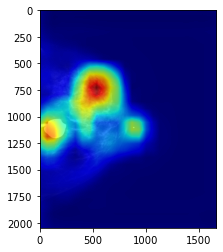

Label:  tensor(1, dtype=torch.uint8)


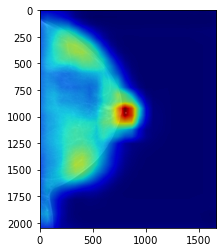

Label:  tensor(1, dtype=torch.uint8)


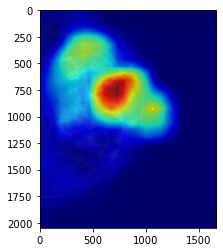

Label:  tensor(1, dtype=torch.uint8)


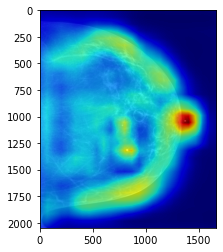

Label:  tensor(1, dtype=torch.uint8)


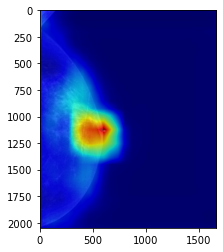

Label:  tensor(1, dtype=torch.uint8)


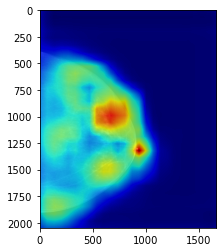

Label:  tensor(1, dtype=torch.uint8)


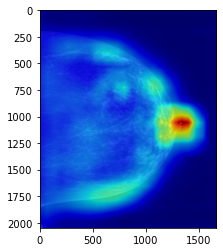

Label:  tensor(1, dtype=torch.uint8)


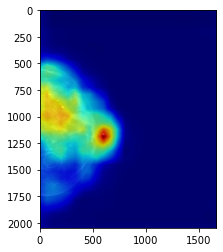

Label:  tensor(1, dtype=torch.uint8)


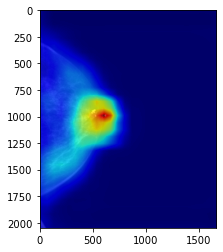

Label:  tensor(1, dtype=torch.uint8)


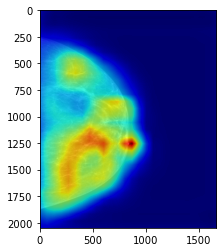

Label:  tensor(1, dtype=torch.uint8)


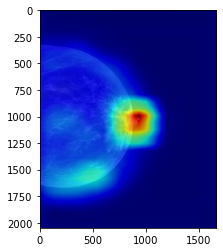

Label:  tensor(1, dtype=torch.uint8)


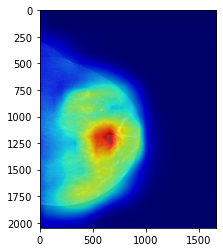

Label:  tensor(1, dtype=torch.uint8)


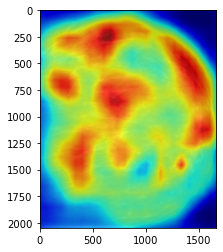

Label:  tensor(1, dtype=torch.uint8)


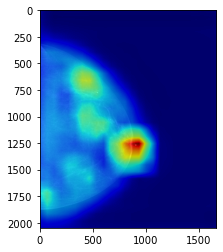

Label:  tensor(1, dtype=torch.uint8)


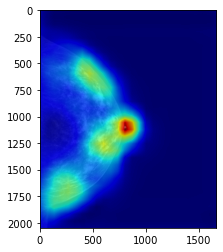

Label:  tensor(1, dtype=torch.uint8)


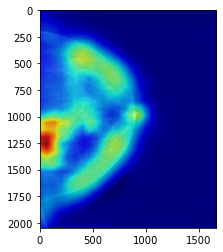

Label:  tensor(1, dtype=torch.uint8)


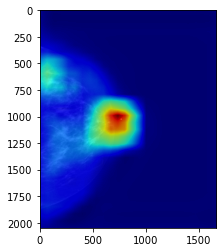

Label:  tensor(1, dtype=torch.uint8)


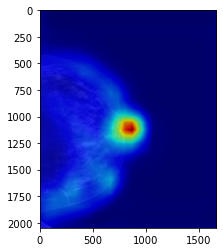

Label:  tensor(1, dtype=torch.uint8)


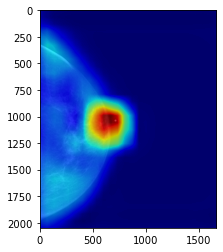

Label:  tensor(1, dtype=torch.uint8)


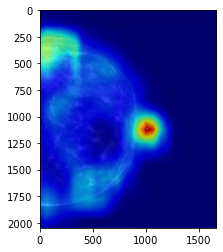

Label:  tensor(1, dtype=torch.uint8)


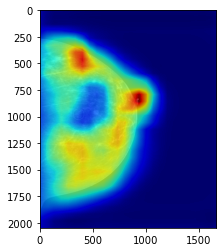

Label:  tensor(1, dtype=torch.uint8)


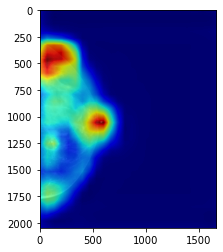

In [33]:
for a in range(len(risk_dataset_t3)):
    if risk_dataset_t3[a]['label'].int() == 1:
        im = risk_dataset_t3[a]['images']['same-cc'].reshape(1, 1, 2048, 1664).type(torch.FloatTensor).to(device)
        print("Label: ", risk_dataset_t3[a]['label'])
        show_heatmap(im, alpha=0.8)

In [ ]:
from captum.attr import IntegratedGradients

In [ ]:
ig = IntegratedGradients(model)
attributions, delta = ig.attribute(img, target=0, return_convergence_delta=True)
print('IG Attributions:', attributions)
print('Convergence Delta:', delta)